In [1]:
import pandas as pd
import os

from pyspark import SparkContext
from pyspark.sql import SQLContext

from loader1 import load_spark_df, load_pandas_df
import pyspark
from pyspark.sql.functions import split, explode
from pyspark.sql import Row
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.neighbors import NearestNeighbors


In [2]:
def load_pandas_df(dir_name, file_name, use_cache=True):
    """
        Code to load Pandas DataFrame
    """
    cache_path = os.path.join(CACHE_DIR, f'{dir_name}_{file_name}.msgpack')
    if os.path.exists(cache_path) and use_cache:
        print(f'Loading from {cache_path}')
        df = pd.read_msgpack(cache_path)
    else:
        csv_path = os.path.join(DATA_DIR, dir_name, file_name + '.csv')
        df = pd.read_csv(csv_path)
        pd.to_msgpack(cache_path, df)
        print(f'Dumping to {cache_path}')
    return df

def load_spark_df(dir_name, file_name, use_cache=True):
    """
        Code to load Spark DataFrame using load_pandas_df function
    """
    cache_path = os.path.join(CACHE_DIR,
                              f'spark_{dir_name}_{file_name}.msgpack')
    if os.path.exists(cache_path) and use_cache:
        print(f'Loading from {cache_path}')
        spark_df = pd.read_msgpack(cache_path)
    else:
        pandas_df = load_pandas_df(dir_name, file_name, use_cache=True)
        #        sc = SparkContext.('local','example')  # if using locally
        sc = SparkContext.getOrCreate()  # else get multiple contexts error
        sql_sc = SQLContext(sc)
        spark_df = sql_sc.createDataFrame(pandas_df)
    return spark_df

In [3]:
# 2.Data and methods

dir_name = 'ml-latest-small'
CACHE_DIR = './cache/'
DATA_DIR = './data/'
movies_spark_df = load_spark_df(dir_name, 'movies', use_cache=True)
ratings_spark_df = load_spark_df(dir_name, 'ratings', use_cache=True)

Loading from ./cache/ml-latest-small_movies.msgpack


/media/anirudh/Data/Code/anaconda3/envs/pers/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.


Loading from ./cache/ml-latest-small_ratings.msgpack


In [4]:
def get_als_model_rmse(df, rank):
    train, test = df.randomSplit([0.9, 0.1], seed=1)
    als = ALS(
        maxIter=5,
        regParam=0.09,
        rank=rank,
        userCol="userId",
        itemCol="movieId",
        ratingCol="rating",
        coldStartStrategy="drop",
        nonnegative=True)

    model = als.fit(train)
    evaluator = RegressionEvaluator(
        metricName="rmse", labelCol="rating", predictionCol="prediction")
    predictions = model.transform(test)
    rmse = evaluator.evaluate(predictions)
    print(f'RMSE is {rmse}')
    return (predictions, model, rmse)


def get_nearest_neighbours_model():
    from scipy.sparse import csr_matrix
    #make an object for the NearestNeighbors Class.
    model_knn = NearestNeighbors(
        metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
    # fit the dataset
    model_knn.fit(movie_user_mat_sparse)


def calculate_coverage(model):
    user_recos = model.recommendForAllUsers(numItems=10)
    #    breakpoint()

    df1 = user_recos.select(explode(user_recos.recommendations).alias('col1'))
    df2 = df1.select('col1.*')
    df3 = df2.select('movieId').distinct()
    df4 = df3.toPandas()
    movie_set = df4['movieId'].values
    #    recos_list = user_recos.select('recommendations').collect()
    #    recos_list = [el for el in recos_list]
    #    recos_list = [x for b in recos_list for x in b]
    #    recos_list = [item for sublist in recos_list for item in sublist]
    #    movie_list = [row['movieId'] for row in recos_list]
    #    movie_set = list(set(movise_list))
    return movie_set


def get_best_rank(df):
    #based on rmse
    rmse_dict = {}
    coverage_dict = {}
    for rank in [1, 2, 4, 8, 16, 32, 64, 128]:
        #    for rank in [64, 128]:
        print(f'Rank is {rank}')
        _, model, rmse = get_als_model_rmse(df, rank)
        coverage = calculate_coverage(model)
        rmse_dict[rank] = rmse
        coverage_dict[rank] = coverage
    return rmse_dict, coverage_dict


def get_rank_report(df):
    rank = 64
    predictions, model, rmse = get_als_model_rmse(df, rank)
    valuesAndPreds = predictions.rdd.map(lambda x: (x.rating, x.prediction))
    regressionmetrics = RegressionMetrics(valuesAndPreds)
    rankingmetrics = RankingMetrics(valuesAndPreds)
    print("MAE = {regressionmetrics.meanAbsoluteError}")


def cross_validation(df):
    """
        Cross validation
    """
    train, test = df.randomSplit([0.9, 0.1], seed=1)
    
    als = ALS(
        userCol="userId",
        itemCol="movieId",
        ratingCol="rating",
        coldStartStrategy="drop",
        nonnegative=True)
    
    evaluator = RegressionEvaluator(
        metricName="rmse", labelCol="rating", predictionCol="prediction")
    
    paramGrid = ParamGridBuilder() \
    .addGrid(als.maxIter, [3]) \
    .addGrid(als.regParam, [0.01,0.1]) \
    .addGrid(als.rank, [64, 128]) \
    .build()
    
        
    crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator= RegressionEvaluator( metricName="rmse", 
                                                          labelCol="rating",
                                                          predictionCol="prediction"),
                            numFolds=3) 

    # Run cross-validation, and choose the best set of parameters.
    cvModel = crossval.fit(train)
    predictions = cvModel.transform(test)
    rmse = evaluator.evaluate(predictions)
    print(f'RMSE is {rmse}')

In [5]:
cross_validation(ratings_spark_df)

RMSE is 0.8694231438939172


In [6]:
rmse_dict = get_best_rank(ratings_spark_df)
get_rank_report(ratings_spark_df)
#print("RMSE=" + str(rmse_dict))
#predictions.show()

Rank is 1
RMSE is 0.8871014213037948
Rank is 2
RMSE is 0.8974948664149236
Rank is 4
RMSE is 0.8800144934123687
Rank is 8
RMSE is 0.8801364316892615
Rank is 16
RMSE is 0.8748032123241689
Rank is 32
RMSE is 0.8744625657196862
Rank is 64
RMSE is 0.8747209651359298
Rank is 128
RMSE is 0.8724476209688208
RMSE is 0.8747209651359298
MAE = {regressionmetrics.meanAbsoluteError}


In [15]:
rmse_dict[0].keys()

[dict_keys([1, 2, 4, 8, 16, 32, 64, 128])]

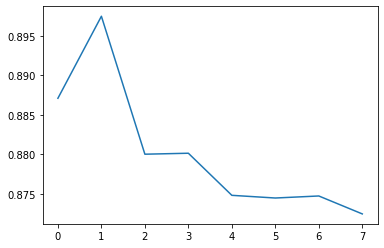

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(rmse_dict[0].values()))
plt.xlabel()
plt.show()